In [ ]:
!pip install git+https://github.com/leehosu01/optopt.git@0.2.0-td3
!pip install --no-cache-dir  --force-reinstall --no-deps  git+https://github.com/leehosu01/optopt.git@0.2.0-td3
!nvidia-smi

  Cloning https://github.com/leehosu01/optopt.git (to revision 0.2.0-td3) to /tmp/pip-req-build-tb70fkkt
  Running command git clone -q https://github.com/leehosu01/optopt.git /tmp/pip-req-build-tb70fkkt
  Running command git checkout -b 0.2.0-td3 --track origin/0.2.0-td3
  Switched to a new branch '0.2.0-td3'
  Branch '0.2.0-td3' set up to track remote branch '0.2.0-td3' from 'origin'.
  Cloning https://github.com/leehosu01/optopt.git (to revision 0.2.0-td3) to /tmp/pip-req-build-vectulrw
  Running command git clone -q https://github.com/leehosu01/optopt.git /tmp/pip-req-build-vectulrw
  Running command git checkout -b 0.2.0-td3 --track origin/0.2.0-td3
  Switched to a new branch '0.2.0-td3'
  Branch '0.2.0-td3' set up to track remote branch '0.2.0-td3' from 'origin'.
  Created wheel for optimizer-optimizer: filename=optimizer_optimizer-0.2.0_td3-py3-none-any.whl size=24809 sha256=7286f8c04481e7edeb1c193fde12d70727fc0bfcf148ddd4bfbec24fec580551
  Stored in directory: /tmp/pip-ephem-wh

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
        TPU_DETECTED =True
        #policy = mixed_precision.Policy('mixed_bfloat16')
        #mixed_precision.set_global_policy(policy)
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy, TPU_DETECTED
#strategy, TPU_DETECTED = auto_select_accelerator()
strategy = tf.distribute.get_strategy()

from tensorflow.keras import datasets, layers, models
#(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()
train_images = train_images.reshape((50000, 32, 32, 3))
test_images = test_images.reshape((10000, 32, 32, 3))

train_images, test_images = train_images / 255.0, test_images / 255.0
def build_dataset(*args):
    return tf.data.Dataset.from_tensor_slices(args).cache().shuffle(1024 *8).batch(256, True)
TR_DT = build_dataset(train_images, train_labels)
VL_DT = build_dataset(test_images, test_labels)
num_classes = 100

In [ ]:
from optopt import manager
from optopt import network as opt_network
import optopt
from adabelief_tf import AdaBeliefOptimizer
def build_model(return_metrics = False):
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), use_bias = False, input_shape=train_images.shape[-3:]))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Activation('elu'))
    model.add(layers.Conv2D(128, (3, 3), use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Activation('elu'))
    model.add(layers.Conv2D(128, (3, 3), use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Activation('elu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes, activation='softmax'))
    if not return_metrics: return model
    norm_layer = tf.keras.layers.Lambda(lambda X: tf.norm(X, 2))
    metrics = []
    metric_names = []
    for lay in model.layers:
        try: 
          name = lay.name + '_kernel_norm'
          metrics.append({'value':tf.keras.layers.Lambda(lambda X: tf.norm(X, 2))(lay.weights, 2), 'name': name})
          metric_names.append(name)
        except: pass
        try: 
          name = lay.name + '_bias_norm'
          metrics.append({'value':tf.keras.layers.Lambda(lambda X: tf.norm(X, 2))(lay.bias, 2), 'name': name})
          metric_names.append(name)
        except: pass
    IN = tf.keras.layers.Input(train_images.shape[-3:])
    model2 = tf.keras.models.Model(IN, [model(IN)] + [M['value'] for M in metrics])

    return model, metric_names
def model_compile(label_smoothing, **opt_params):
    def scc_ls(label_smoothing):
        def _sub(y_true, y_pred):
            y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, tf.int32), num_classes))
            y_true = y_true * (1.0 - label_smoothing) + (label_smoothing / num_classes)
            return tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return _sub
    class SCC_LS(tf.keras.metrics.Metric):
        def __init__(self, label_smoothing, name, **kwargs):
            super(SCC_LS, self).__init__(name=name, **kwargs)
            self.mean = tf.keras.metrics.Mean()
            self.label_smoothing = label_smoothing
        def update_state(self, y_true, y_pred, sample_weight=None):
            y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, tf.int32), num_classes))
            y_true = y_true * (1.0 - self.label_smoothing) + (self.label_smoothing / num_classes)
            loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
            self.mean.update_state(tf.reduce_mean(loss))
        def reset_state(self):self.mean.reset_state()
        def result(self):return self.mean.result()
    with strategy.scope():
        model = opt_network.weight_metrics_wrapper(build_model())
        model.compile(optimizer=AdaBeliefOptimizer(**opt_params),
                      loss=scc_ls(label_smoothing),
                      metrics= [tf.keras.metrics.SparseTopKCategoricalAccuracy(k= 1 , name = f"acc")] + \
                              [tf.keras.metrics.SparseTopKCategoricalAccuracy(k= i , name = f"sca_{i}") for i in range(2, 5)] + \
                              [SCC_LS((i+0.5) / 10, name = f"scc_{i}") for i in range(10)]
                      )
    return model
weight_metrics = opt_network.weight_metrics_wrapper(build_model()).get_metric_names()


max_epochs = 20
base_feature = [f"sca_{i}" for i in range(2, 5)] + [f"scc_{i}" for i in range(10)]
config = optopt.Config(sequence_length = max_epochs,
                log_interval = 1,
                collect_episodes_for_env_testing = 0,
                policy_save_interval = 4,)
optim = manager.Manager(using_features = [J+I for I in base_feature for J in ['', 'val_']] + weight_metrics,
                        objective = 'val_acc',
                        direction = 'maximize',
                        config = config)

opt_parameter = {
                    'label_smoothing':optim.Variables.loguniform('label_smoothing', 0.01, 0.5),
                    'learning_rate':optim.Variables.loguniform('learning_rate', 1e-5, 3e-2),
                    'beta_1':optim.Variables.loguniform('beta_1', 0.05, 0.25, post_processing = (lambda X: 1-X)),
                    'beta_2':optim.Variables.loguniform('beta_2', 0.0001, 0.2, post_processing = (lambda X: 1-X)),
                    'epsilon':optim.Variables.loguniform('epsilon', 1e-14, 1e-4),
                    'weight_decay':optim.Variables.loguniform('weight_decay', 1e-8, 1e-2),
                    'rectify':True,
                    'amsgrad':False,
                    'sma_threshold':5.0,
                    'print_change_log':False}
model = model_compile(**opt_parameter)

opt_parameter['learning_rate'].assign(0.)
model.fit(TR_DT, epochs=1, steps_per_epoch=1)
opt_W = model.optimizer.get_weights()
optim.compile()

1/1 [==============================] - 5s 5s/step - loss: 5.6643 - acc: 0.0078 - sca_2: 0.0117 - sca_3: 0.0195 - sca_4: 0.0273 - scc_0: 5.6665 - scc_1: 5.6560 - scc_2: 5.6455 - scc_3: 5.6350 - scc_4: 5.6245 - scc_5: 5.6141 - scc_6: 5.6036 - scc_7: 5.5931 - scc_8: 5.5826 - scc_9: 5.5721 - conv2d_weight_0_norm: 2.3535 - batch_normalization_weight_0_norm: 5.6569 - batch_normalization_weight_1_norm: 0.0000e+00 - batch_normalization_weight_2_norm: 0.0116 - batch_normalization_weight_3_norm: 5.6010 - conv2d_weight_0_norm_1: 7.1553 - batch_normalization_weight_0_norm_1: 11.3137 - batch_normalization_weight_1_norm_1: 0.0000e+00 - batch_normalization_weight_2_norm_1: 0.0284 - batch_normalization_weight_3_norm_1: 11.2273 - conv2d_weight_0_norm_2: 11.3220 - batch_normalization_weight_0_norm_2: 11.3137 - batch_normalization_weight_1_norm_2: 0.0000e+00 - batch_normalization_weight_2_norm_2: 0.0687 - batch_normalization_weight_3_norm_2: 11.2789 - dense_weight_0_norm: 12.9409 - dense_weight_1_norm: 0

GEN 0
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0 False 0


Instructions for updating:
rename to distribute_datasets_from_function


Instructions for updating:
rename to distribute_datasets_from_function


start training


training =  False
ENV._step => call set_action tf.Tensor([0.6779257  0.61973375 0.3609753  0.4882964  0.44061893 0.34573358], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 6s 29ms/step - loss: 4.0935 - acc: 0.1175 - sca_2: 0.1828 - sca_3: 0.2331 - sca_4: 0.2722 - scc_0: 4.0704 - scc_1: 4.2023 - scc_2: 4.3342 - scc_3: 4.4661 - scc_4: 4.5980 - scc_5: 4.7299 - scc_6: 4.8619 - scc_7: 4.9938 - scc_8: 5.1257 - scc_9: 5.2576 - conv2d_weight_0_norm: 2.3483 - batch_normalization_weight_0_norm: 5.6580 - batch_normalization_weight_1_norm: 0.0216 - batch_normalization_weight_2_norm: 0.6718 - batch_normalization_weight_3_norm: 2.5122 - conv2d_weight_0_norm_1: 7.1880 - batch_normalization_weight_0_norm_1: 11.3139 - batch_normalization_weight_1_norm_1: 0.0412 - batch_normalization_weight_2_norm_1: 1.5629 - batch_normalization_weight_3_norm_1: 6.8646 - conv2d_weight_0_norm_2: 11.3538 - batch_normalization_weight_0_norm_2: 11.2879 - batc

training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  False
ENV._step => call set_action tf.Tensor([0.32870403 0.77993095 0.17754446 0.45829532 0.30479708 0.7620186 ], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 6s 28ms/step - loss: 4.2877 - acc: 0.0888 - sca_2: 0.1427 - sca_3: 0.1840 - sca_4: 0.2186 - scc_0: 4.2777 - scc_1: 4.3771 - scc_2: 4.4765 - scc_3: 4.5760 - scc_4: 4.6754 - scc_5: 4.7748 - scc_6: 4.8742 - scc_7: 4.9736 - scc_8: 5.0731 - scc_9: 5.1725 - conv2d_weight_0_norm: 2.2964 - batch_normalization_weight_0_norm: 5.6575 - batch_normalization_weight_1_norm: 0.0157 - batch_normalization_weight_2_norm: 0.5334 - batch_normalization_weight_3_norm: 2.4971 - conv2d_weight_0_norm_1: 7.1747 - batch_normalization_weight_0_norm_1: 11.3128 - batch_normalization_weight_1_norm_1: 0.0276 - batch_normalization_weight_2_norm_1: 1.4065 - batch_nor

training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  False
ENV._step => call set_action tf.Tensor([0.71959764 0.6657081  0.7148138  0.6629884  0.64542663 0.74666214], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 6s 30ms/step - loss: 3.8951 - acc: 0.1749 - sca_2: 0.2596 - sca_3: 0.3195 - sca_4: 0.3648 - scc_0: 3.7319 - scc_1: 3.9267 - scc_2: 4.1215 - scc_3: 4.3164 - scc_4: 4.5112 - scc_5: 4.7060 - scc_6: 4.9008 - scc_7: 5.0957 - scc_8: 5.2905 - scc_9: 5.4853 - conv2d_weight_0_norm: 2.3345 - batch_normalization_weight_0_norm: 5.6695 - batch_normalization_weight_1_norm: 0.0941 - batch_normalization_weight_2_norm: 0.5328 - batch_normalization_weight_3_norm: 2.4961 - conv2d_weight_0_norm_1: 7.3250 - batch_normalization_weight

training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  False
ENV._step => call set_action tf.Tensor([0.24729387 0.73075056 0.76330346 0.696968   0.7677814  0.60983604], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 6s 32ms/step - loss: 3.9120 - acc: 0.1740 - sca_2: 0.2612 - sca_3: 0.3226 - sca_4: 0.3687 - scc_0: 3.7010 - scc_1: 3.9062 - scc_2: 4.1114 - scc_3: 4.3167 - scc_4: 4.5219 - scc_5: 4.7271 - scc_6: 4.9323 - scc_7: 5.1376 - scc_8: 5.3428 - scc_9: 5.5480 - conv2d_weight_0_norm: 2.4562 - batch_normalization_weight_0_norm: 5.6634 - batch_normalization_weight_1_norm: 0.1753 - batch_normalization_weigh

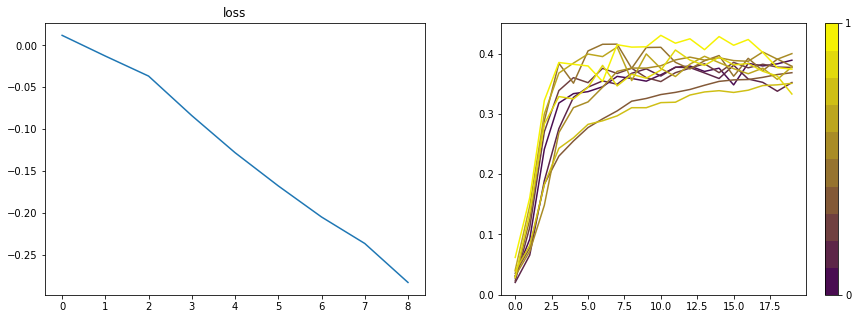

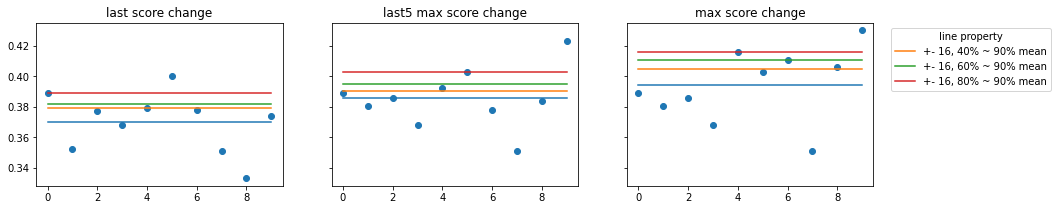

GEN 10
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0 False 0
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  False
ENV._step => call set_action tf.Tensor([0.48305982 0.8009336  0.38643998 0.72569835 0.8582116  0.5751669 ], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 6s 32ms/step - loss: 3.9213 - acc: 0.1838 - sca_2: 0.2719 - sca_3: 0.3337 - sca_4: 0.3828 - scc_0: 3.6609 - scc_1: 3.8761 - scc_2: 4.0913 - scc_3: 4.3065 - scc_4: 4.5217 - scc_5: 4.7369 - scc_6: 4.9521 - scc_7: 5.1673 - scc_8: 5.3

training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  False
ENV._step => call set_action tf.Tensor([0.7725435  0.7757957  0.6835936  0.49011818 0.36087897 0.18548505], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 7s 35ms/step - loss: 4.1299 - acc: 0.1153 - sca_2: 0.1798 - sca_3: 0.2285 - sca_4: 0.2673 - scc_0: 4.1071 - scc_1: 4.2336 - scc_2: 4.3602 - scc_3: 4.4868 - scc_4: 4.6133 - scc_5: 4.7399 - scc_6: 4.8664 - scc_7: 4.9930 - scc_8: 5.1195 - scc_9: 5.2461 - conv2d_weight_0_norm: 

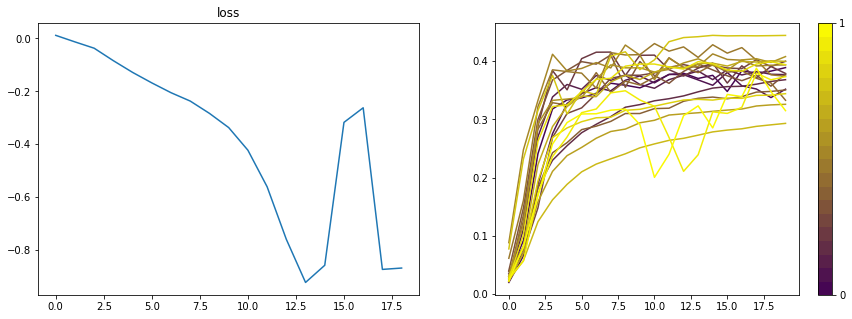

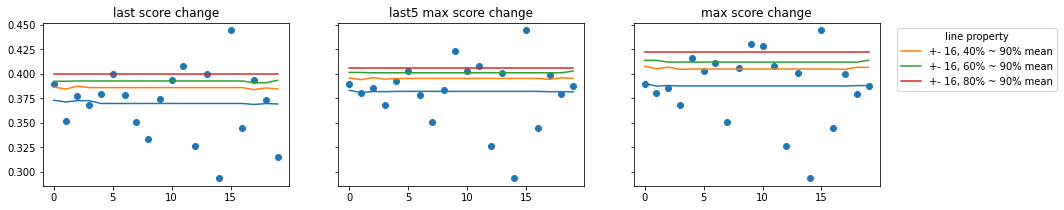

GEN 20
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0 False 0
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  False
ENV._step => call set_action tf.Tensor([0.23077966 0.3903772  0.2466277  0.38789228 0.25089943 0.36346728], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 7s 34ms/step - loss: 4.8326 - acc: 0.0365 - sca_2: 0.0637 - sca_3: 0.0862 - sca_4: 0.1071 - scc_0: 4.8346 - 

training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  False
ENV._step => call set_action tf.Tensor([0.19080801 0.7750839  0.293236   0.3811926  0.17118616 0.5475512 ], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 7s 37ms/step - loss: 4.6117 - acc: 0.0527 - sca_2: 0.0889 - sca_3: 0.1165 - sca_4: 0.1409 - scc_0: 4.6151 - scc_1: 4.6756 - scc_2: 4.7360 - scc_3: 4.796

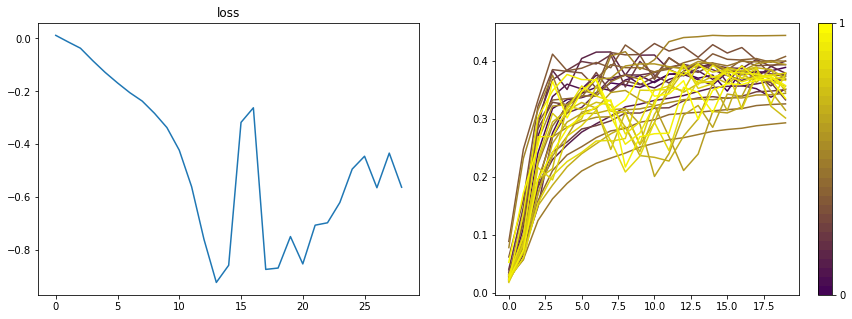

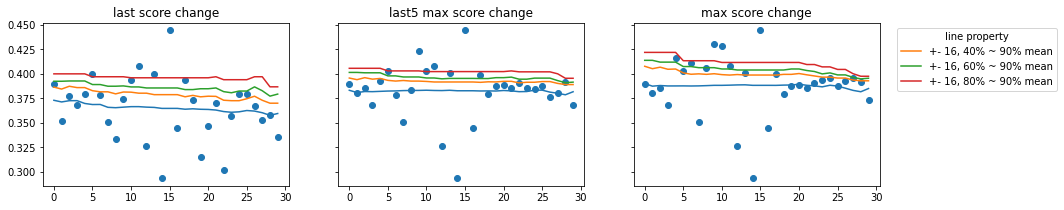

GEN 30
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0 False 0
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  False
ENV._step => call set_action tf.Tensor([0.56912005 0.1483663  0.7117727  0.6015364  0.39100343 0.6572624 ], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [====================

training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  True
training =  False
training =  False
training =  True
training =  True
training =  True
training =  False
training =  False
ENV._step => call set_action tf.Tensor([0.28168407 0.3418745  0.7045686  0.41935    0.4368926  0.5466161 ], shape=(6,), dtype=float32)
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 9s 46ms/step - loss: 4.5513 - 

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors as cmaps
import matplotlib
import numpy as np
def show_enhance(history):
    color_0 = np.asarray([65,0,85, 255])
    color_1 = np.asarray([255, 255,0, 255])
    cmap = []

    fig, axs = plt.subplots(1, 2, figsize = (15, 5))

    for i, hist in enumerate(history):
      progress = (i+0.5) / len(history)
      color = color_1 * progress + color_0 * (1. - progress)
      color = color/255.01
      cmap.append(color)
      axs[1].plot(hist.history['val_acc'], color = color)
    axs[1].set_title('each episode history')

    cmap = cmaps.ListedColormap(cmap)
    sm = matplotlib.cm.ScalarMappable(cmap = cmap)
    fig.colorbar(sm, ticks=np.arange(len(history)))

    axs[0].plot(optim.agent.get_history())
    axs[0].set_title('agent loss')
    plt.savefig('history.png')
    plt.close(fig)
    #plt.show()
    def mean_of_percentile(X, low, upp):return np.mean( sorted(X)[int(len(X) * low):int(len(X) * upp)] )

    fig, axs = plt.subplots(1, 3, sharey = True, figsize = (15, 3))

    finals = [hist.history['val_acc'][-1] for hist in history]
    ax_plt = axs[0]
    ax_plt.scatter(np.arange(len(finals)), finals)
    ax_plt.plot([np.mean(finals[i-len(finals)-16:i + 16]) for i in range(len(finals))], label = "+- 16 mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.4, 0.9) for i in range(len(finals))], label = "+- 16, 40% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.6, 0.9) for i in range(len(finals))], label = "+- 16, 60% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.8, 0.9) for i in range(len(finals))], label = "+- 16, 80% ~ 90% mean")
    #ax_plt.legend()
    ax_plt.set_title('last score change')
    #plt.show()

    finals = [max(hist.history['val_acc'][-5:]) for hist in history]
    ax_plt = axs[1]
    ax_plt.scatter(np.arange(len(finals)), finals)
    ax_plt.plot([np.mean(finals[i-len(finals)-16:i + 16]) for i in range(len(finals))], label = "+- 16 mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.4, 0.9) for i in range(len(finals))], label = "+- 16, 40% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.6, 0.9) for i in range(len(finals))], label = "+- 16, 60% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.8, 0.9) for i in range(len(finals))], label = "+- 16, 80% ~ 90% mean")
    #ax_plt.legend()
    ax_plt.set_title('last5 max score change')
    #plt.show()

    finals = [max(hist.history['val_acc']) for hist in history]
    ax_plt = axs[2]
    ax_plt.scatter(np.arange(len(finals)), finals)
    ax_plt.plot([np.mean(finals[i-len(finals)-16:i + 16]) for i in range(len(finals))], label = "+- 16 mean")
    p1, = ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.4, 0.9) for i in range(len(finals))], label = "+- 16, 40% ~ 90% mean")
    p2, = ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.6, 0.9) for i in range(len(finals))], label = "+- 16, 60% ~ 90% mean")
    p3, = ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.8, 0.9) for i in range(len(finals))], label = "+- 16, 80% ~ 90% mean")
    ax_plt.legend()
    ax_plt.set_title('max score change')
    ax_plt.legend(handles=[p1, p2, p3], title='line property', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.savefig('score_change.png')
    plt.close(fig)
    #plt.show()
history = []
for gen in range(200):
    if gen and gen % 10 == 0: show_enhance(history)
    print(f"GEN {gen}")
    new_model = build_model()
    model.set_weights(new_model.get_weights())
    model.optimizer.set_weights(opt_W)
    callback = optim.get_callback()
    #asyncio.run(fitting(model, callback))
    history.append(model.fit(TR_DT, validation_data = VL_DT, epochs = max_epochs, callbacks = [callback]))

In [ ]:

def show_enhance(history):
    color_0 = np.asarray([65,0,85, 255])
    color_1 = np.asarray([255, 255,0, 255])
    cmap = []

    fig, axs = plt.subplots(1, 2, figsize = (15, 5))

    for i, hist in enumerate(history):
      progress = (i+0.5) / len(history)
      color = color_1 * progress + color_0 * (1. - progress)
      color = color/255.01
      cmap.append(color)
      axs[1].plot(hist.history['val_acc'], color = color)
    axs[1].set_title('each episode history')

    cmap = cmaps.ListedColormap(cmap)
    sm = matplotlib.cm.ScalarMappable(cmap = cmap)
    fig.colorbar(sm, ticks=np.arange(len(history)))

    axs[0].plot(optim.agent.get_history())
    axs[0].set_title('agent loss')
    plt.savefig('history.png')
    plt.close(fig)
    #plt.show()
    def mean_of_percentile(X, low, upp):return np.mean( sorted(X)[int(len(X) * low):int(len(X) * upp)] )

    fig, axs = plt.subplots(1, 3, sharey = True, figsize = (15, 3))

    finals = [hist.history['val_acc'][-1] for hist in history]
    ax_plt = axs[0]
    ax_plt.scatter(np.arange(len(finals)), finals)
    ax_plt.plot([np.mean(finals[i-len(finals)-16:i + 16]) for i in range(len(finals))], label = "+- 16 mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.4, 0.9) for i in range(len(finals))], label = "+- 16, 40% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.6, 0.9) for i in range(len(finals))], label = "+- 16, 60% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.8, 0.9) for i in range(len(finals))], label = "+- 16, 80% ~ 90% mean")
    #ax_plt.legend()
    ax_plt.set_title('last score change')
    #plt.show()

    finals = [max(hist.history['val_acc'][-5:]) for hist in history]
    ax_plt = axs[1]
    ax_plt.scatter(np.arange(len(finals)), finals)
    ax_plt.plot([np.mean(finals[i-len(finals)-16:i + 16]) for i in range(len(finals))], label = "+- 16 mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.4, 0.9) for i in range(len(finals))], label = "+- 16, 40% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.6, 0.9) for i in range(len(finals))], label = "+- 16, 60% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.8, 0.9) for i in range(len(finals))], label = "+- 16, 80% ~ 90% mean")
    #ax_plt.legend()
    ax_plt.set_title('last5 max score change')
    #plt.show()

    finals = [max(hist.history['val_acc']) for hist in history]
    ax_plt = axs[2]
    ax_plt.scatter(np.arange(len(finals)), finals)
    ax_plt.plot([np.mean(finals[i-len(finals)-16:i + 16]) for i in range(len(finals))], label = "+- 16 mean")
    p1, = ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.4, 0.9) for i in range(len(finals))], label = "+- 16, 40% ~ 90% mean")
    p2, = ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.6, 0.9) for i in range(len(finals))], label = "+- 16, 60% ~ 90% mean")
    p3, = ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.8, 0.9) for i in range(len(finals))], label = "+- 16, 80% ~ 90% mean")
    ax_plt.legend()
    ax_plt.set_title('max score change')
    ax_plt.legend(handles=[p1, p2, p3], title='line property', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.savefig('score_change.png')
    plt.close(fig)
    #plt.show()
show_enhance(history)

In [ ]:

for gen in range(200, 500):
    if gen and gen % 10 == 0: show_enhance(history)
    print(f"GEN {gen}")
    new_model = build_model()
    model.set_weights(new_model.get_weights())
    model.optimizer.set_weights(opt_W)
    callback = optim.get_callback()
    #asyncio.run(fitting(model, callback))
    history.append(model.fit(TR_DT, validation_data = VL_DT, epochs = max_epochs, callbacks = [callback]))

import tf_agents
tf_agents.trajectories.time_step.restart()